In [54]:
# Holy grail
import pandas as pd
import numpy as np

# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score # evaluation metric used for leaderboard scoring in this competition

# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt # pyplot is an easy to use scripting interface for plotting as oppose to more advanced artistic interface
import seaborn as sns # seaborn is even higher level graphing library built on top of matplotlib

# Machine learning
import optuna # used for finding good hyperparameters for a model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [55]:

train = pd.read_csv("train.csv", index_col="id")
test = pd.read_csv("test.csv", index_col="id")



In [56]:
original = pd.read_csv('horse.csv')
train = pd.concat([train, original], ignore_index=True).drop_duplicates()

# Data analysis

In [57]:
train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1534 non-null   object 
 1   age                    1534 non-null   object 
 2   hospital_number        1534 non-null   int64  
 3   rectal_temp            1474 non-null   float64
 4   pulse                  1510 non-null   float64
 5   respiratory_rate       1476 non-null   float64
 6   temp_of_extremities    1478 non-null   object 
 7   peripheral_pulse       1465 non-null   object 
 8   mucous_membrane        1487 non-null   object 
 9   capillary_refill_time  1502 non-null   object 
 10  pain                   1479 non-null   object 
 11  peristalsis            1490 non-null   object 
 12  abdominal_distention   1478 non-null   object 
 13  nasogastric_tube       1430 non-null   object 
 14  nasogastric_reflux     1428 non-null   object 
 15  naso

## column types
- 11 numerical d_types

- 17 categorical d_types

In [59]:
train.isna().sum().sort_values()

surgery                    0
lesion_3                   0
lesion_2                   0
lesion_1                   0
surgical_lesion            0
cp_data                    0
outcome                    0
age                        0
hospital_number            0
pulse                     24
packed_cell_volume        29
capillary_refill_time     32
total_protein             33
peristalsis               44
mucous_membrane           47
pain                      55
abdominal_distention      56
temp_of_extremities       56
respiratory_rate          58
rectal_temp               60
peripheral_pulse          69
rectal_exam_feces        102
nasogastric_tube         104
nasogastric_reflux       106
abdomen                  118
abdomo_appearance        165
abdomo_protein           198
nasogastric_reflux_ph    246
dtype: int64

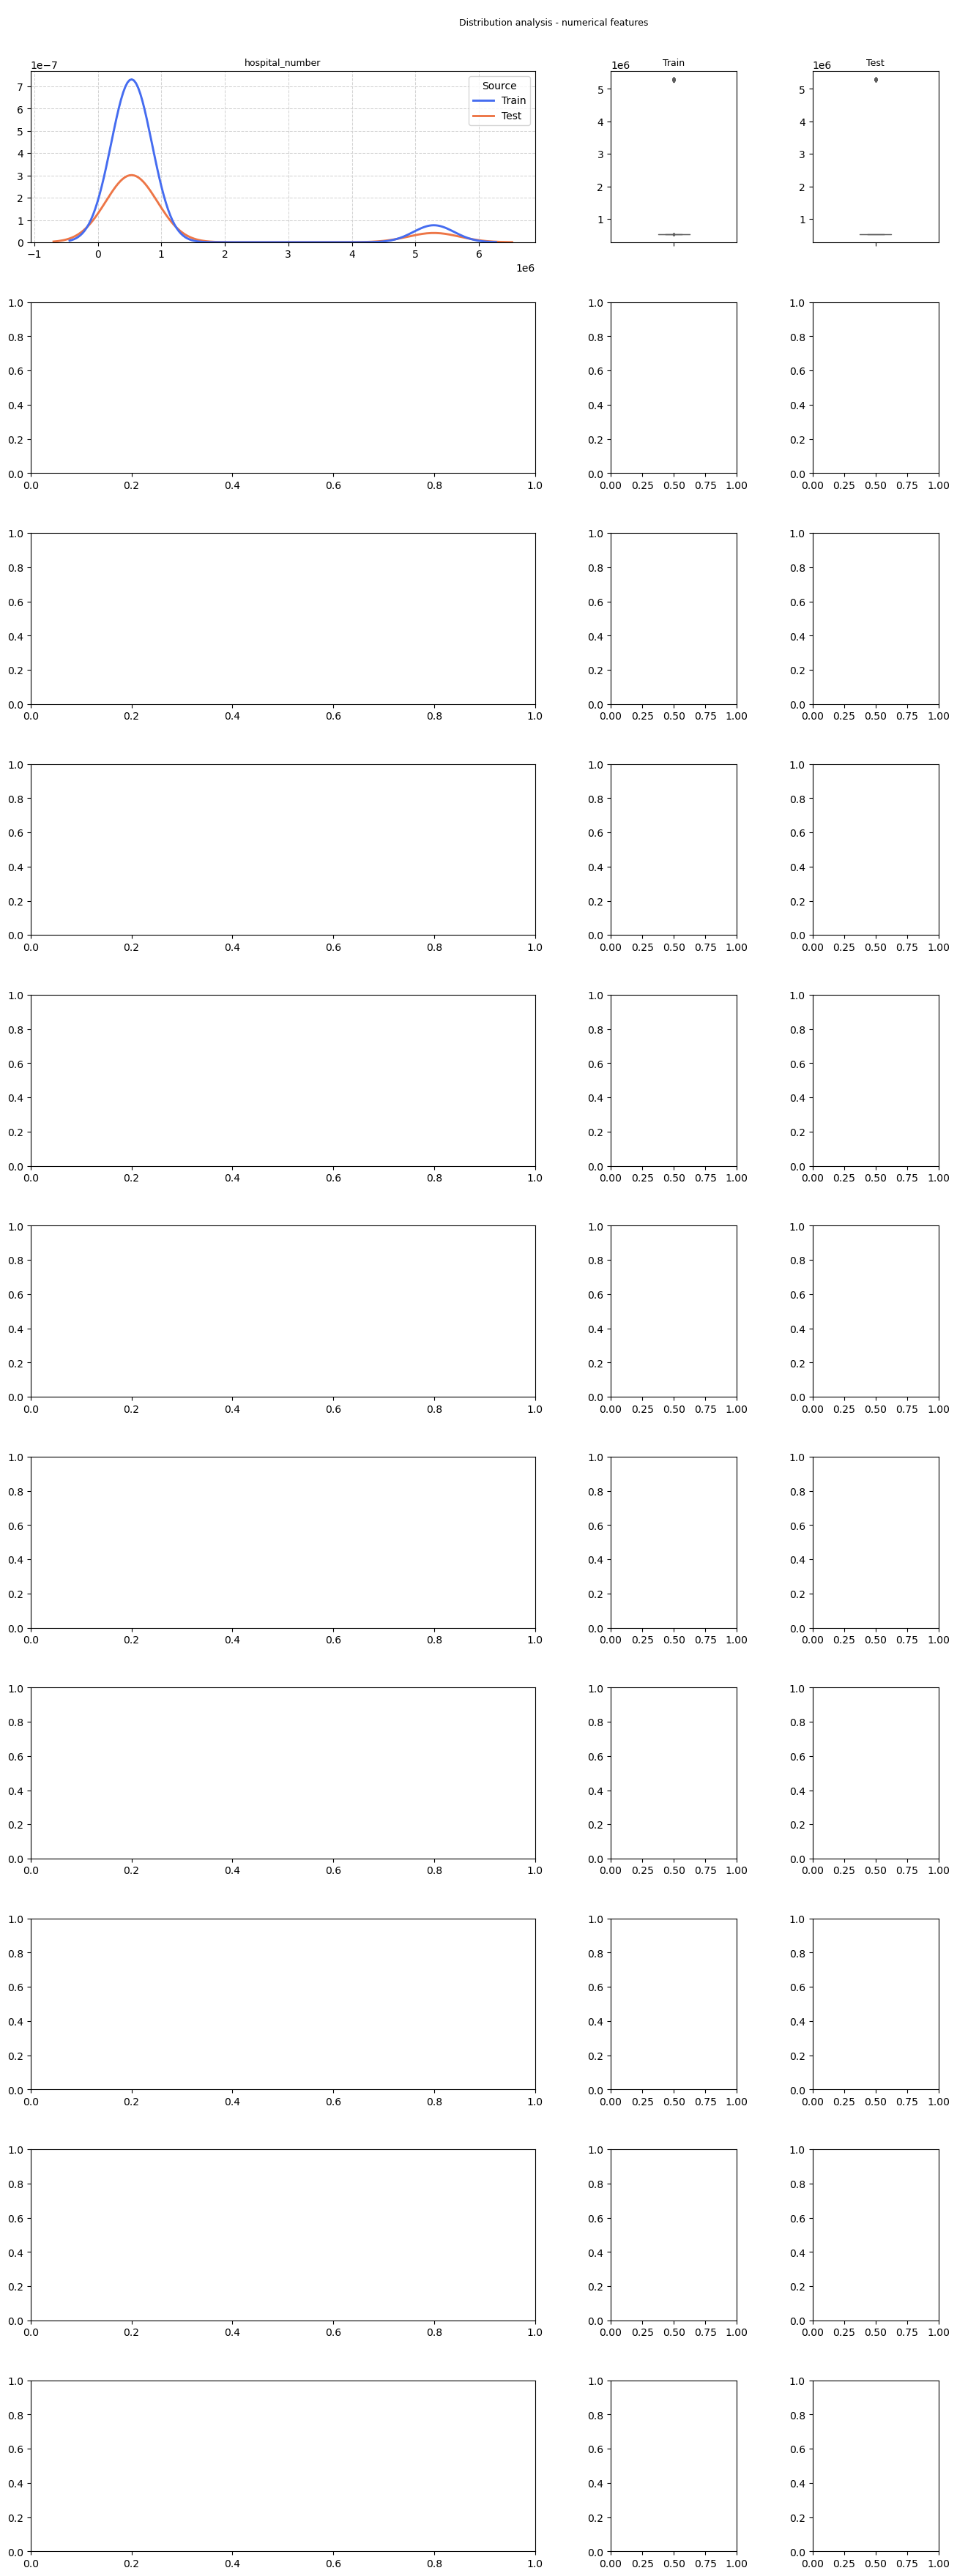

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [60]:

num = train.select_dtypes(include=['int64', 'float64']).columns
df = pd.concat([train[num].assign(Source='Train'), test[num].assign(Source ='Test')], ignore_index=True)

#use of more advanced artistic matplotlib interface(see axes)
fig, axes = plt.subplots(len(num), 3, figsize = (16, len(num) * 4), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80,0.20,0.20]})

for i, col in enumerate(num):
    ax = axes[i,0]
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette = ['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular = False, ax = ax) #use of seaborn with artistic interface
    ax.set_title(f"\n{col}", fontsize=9)
    ax.grid(visible=True, which="both", linestyle = "--", color = "lightgrey", linewidth = 0.75)
    ax.set(xlabel='', ylabel='')
    
    ax = axes[i, 1]
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.92, fliersize = 2.25, color = "#456cf0", ax = ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title("Train", fontsize=9)
    
    ax = axes[i, 2]
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize = 2.25, color = "#ed7647", ax = ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title("Test", fontsize=9)
    
    plt.suptitle(f"\n Distribution analysis - numerical features", fontsize=9, y=0.9, x=0.57)
    plt.show()

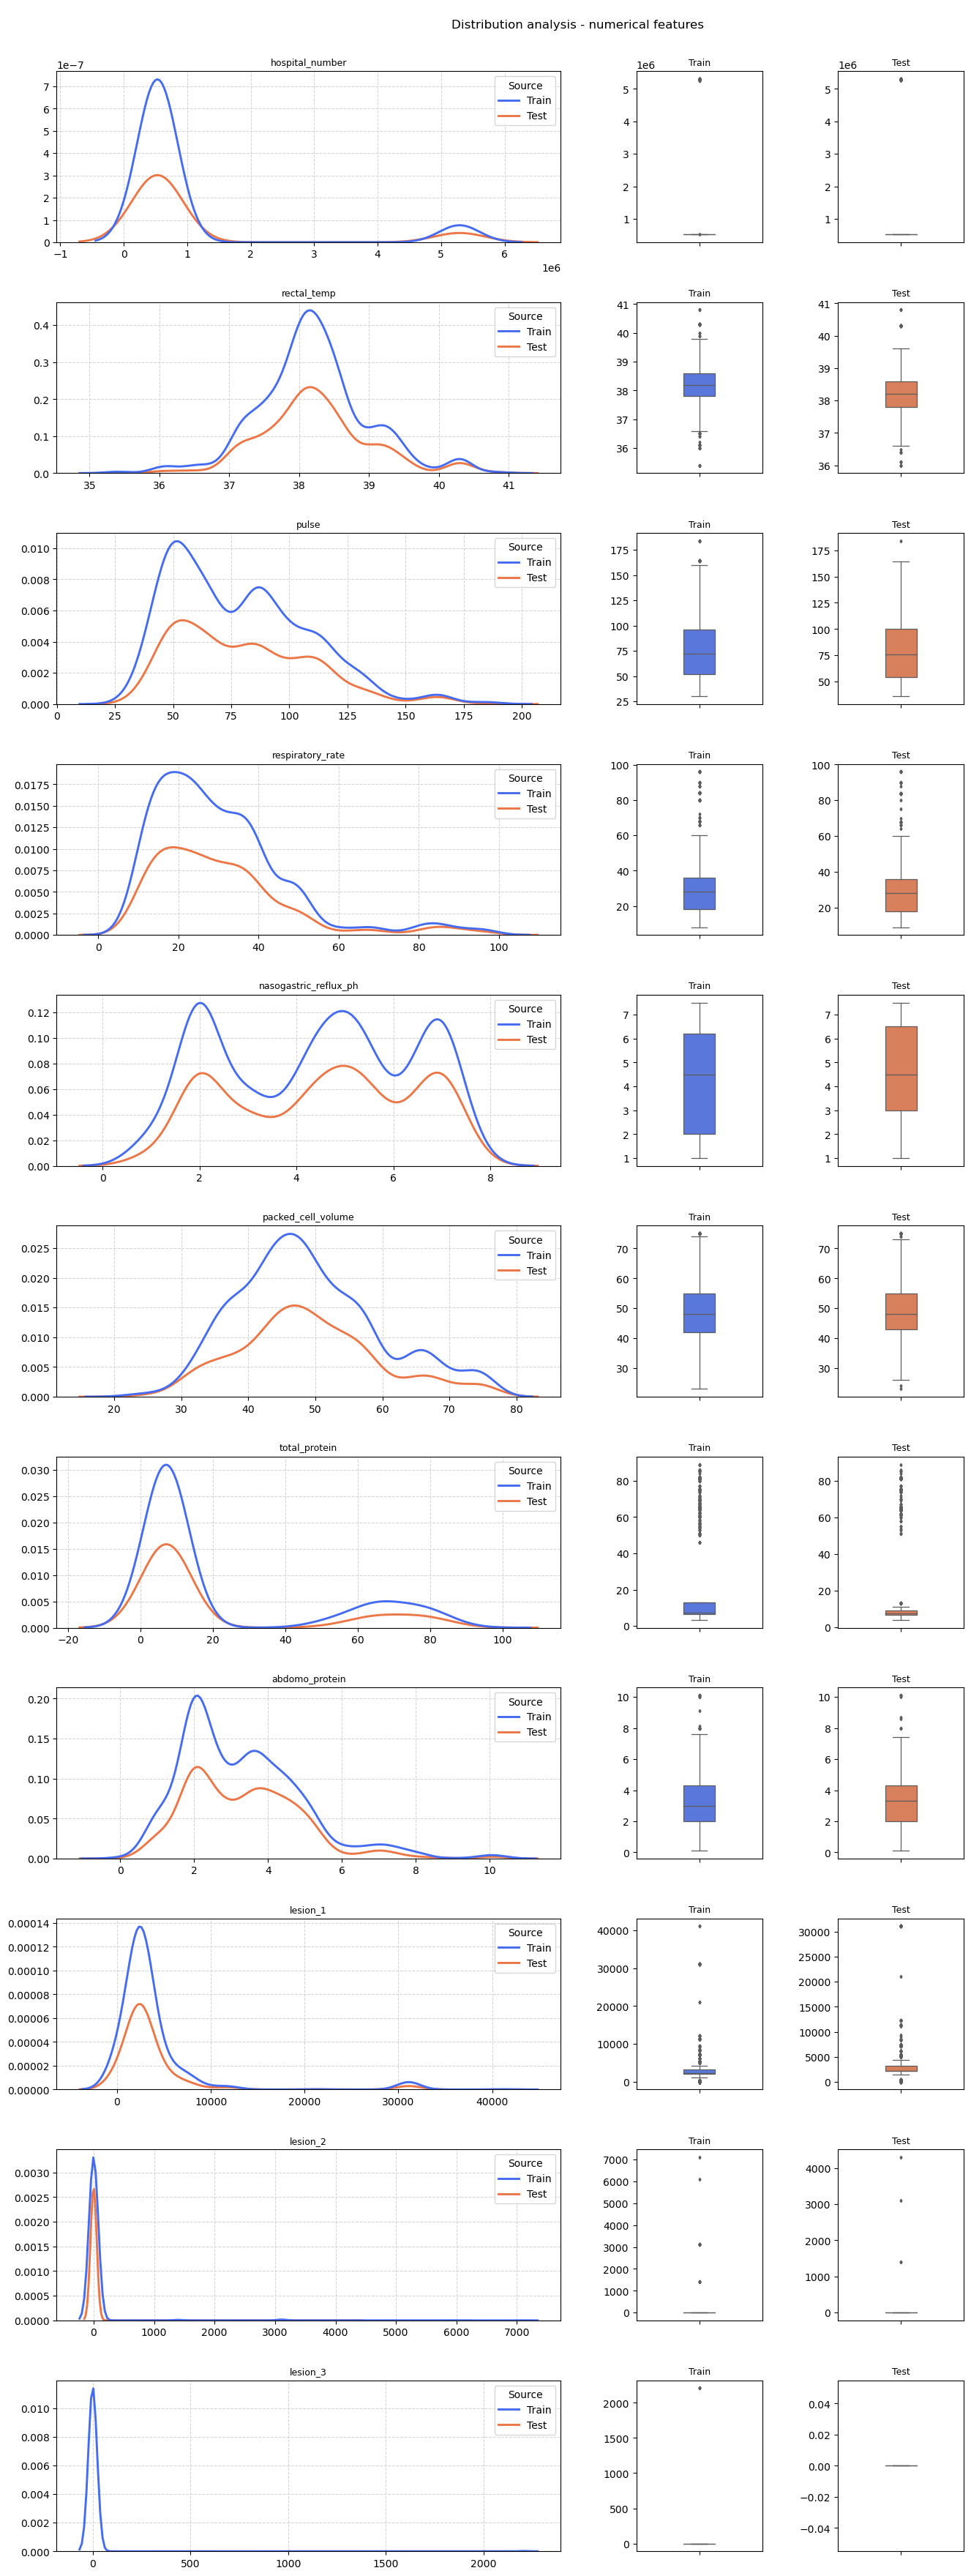

In [61]:
num = train.select_dtypes(include=['int64','float64']).columns

df = pd.concat([train[num].assign(Source = 'Train'), test[num].assign(Source = 'Test')], ignore_index = True)

# Use of more advanced artistic matplotlib interface (see the axes)
fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})

for i,col in enumerate(num):
    ax = axes[i,0]
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
    ax.set_title(f"\n{col}",fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')

    ax = axes[i,1]
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Train", fontsize = 9)

    ax = axes[i,2]
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Test", fontsize = 9)

plt.suptitle(f'\nDistribution analysis - numerical features',fontsize = 12, y = 0.9, x = 0.57)
plt.show()

✅ Great : Distributions of individual numerical features are very close to each other so there doesn't seem to be any data drift!

📔 Matplotlib layers: Matplotlib provides two main interfaces for creating plots: the pyplot interface (also known as the scripting layer) and the object interface (also known as the artist layer). Object interface used in above dash provides more control and flexibility, allowing you to create more complex and customized charts. It requires you to create a figure and an axis explicitly. Basically if you ever see ax or fig used then you know your dealing with a artistic layer.

In [62]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

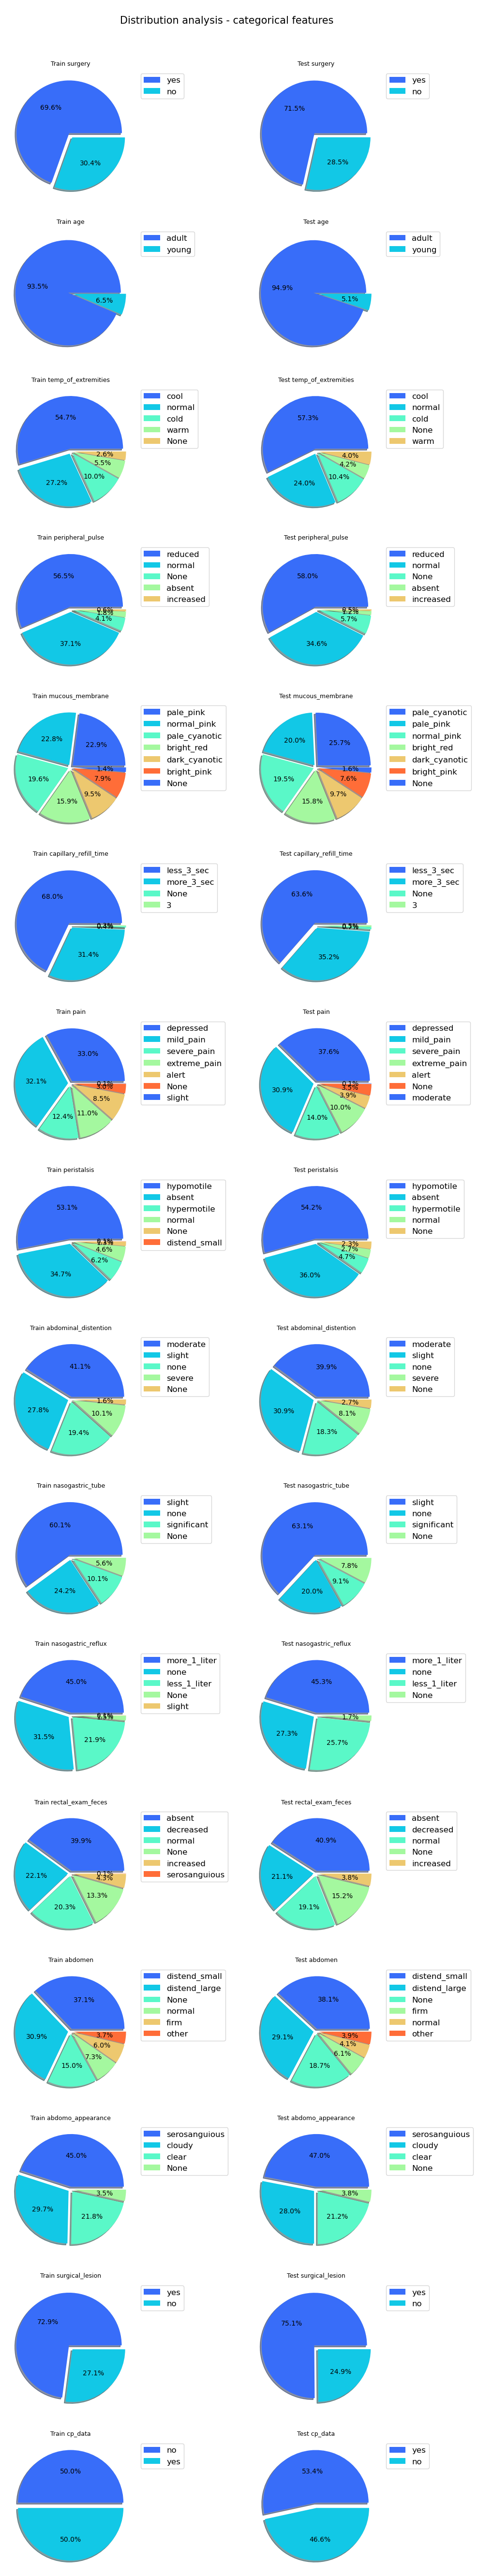

In [63]:
sns.set_palette('rainbow')

num = train.drop(columns='outcome').select_dtypes(include=['object']).columns

df = pd.concat([train[num].assign(Source = 'train'), 
                test[num].assign(Source = 'test')], 
               axis=0, ignore_index = True)

fig, axes = plt.subplots(len(num), 2 ,figsize = (12, len(num) * 4.2))

for i,col in enumerate(num):
    train_dist = df.loc[df.Source == 'train', [col]].value_counts()
    test_dist = df.loc[df.Source == 'test', [col]].value_counts()
    
    ax = axes[i,0]
    ax.pie(train_dist, shadow=True, explode=[.05]*len(train_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in train_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Train {col}',fontsize = 9)

    ax = axes[i,1]
    ax.pie(test_dist, shadow=True, explode=[.05]*len(test_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in test_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Test {col}',fontsize = 9)


plt.suptitle(f"\nDistribution analysis - categorical features\n",fontsize = 15, y = 0.9, x = 0.57)
plt.show()

✅ Great : Distributions of individual categorical columns have almost identical distributions so there is no data drift!

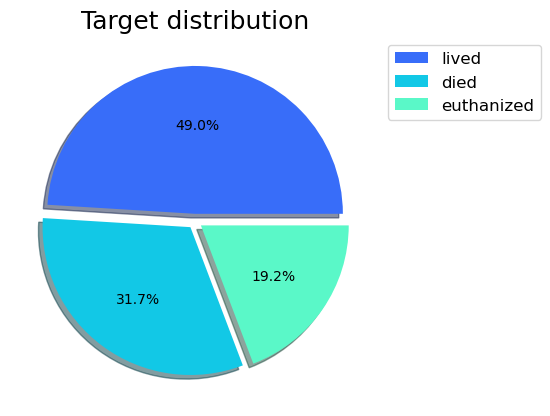

<Figure size 500x1000 with 0 Axes>

In [64]:
target_dist = train['outcome'].value_counts()

plt.pie(target_dist, shadow=True, explode=[.05,.05,.05], autopct='%.1f%%')

plt.title('Target distribution', size=18)
plt.legend(target_dist.index, loc='upper left', bbox_to_anchor=(1,1), fontsize=12)

plt.figure(figsize=(5,10))
plt.show()

✅ Great : Our target is pretty well balanced. After EDA it seems that this competition will be fairly easy and light weight. There is little missing values, not many features, balanced target distribution and it's not a time series.

📔 Feature/target distribution : Investing distributions of your numerical and categorical features is one of the most crucial steps in data analysis. This way you understand data better and can discover a lot of red flags hiding in it like:
data drift - training and testing data distriubtion are different
imbalanced target - one class has significantly more samples than the other(s), which can lead to biased models that favor the majority class, only in classificaiton problems
outliers - data points that differ from the other observations in a dataset
bimodality - can indicate that your data is actually a mix of two different distributions
If a column has one or more of those issues you can try dropping it and seeing if it improves your leaderboard score.

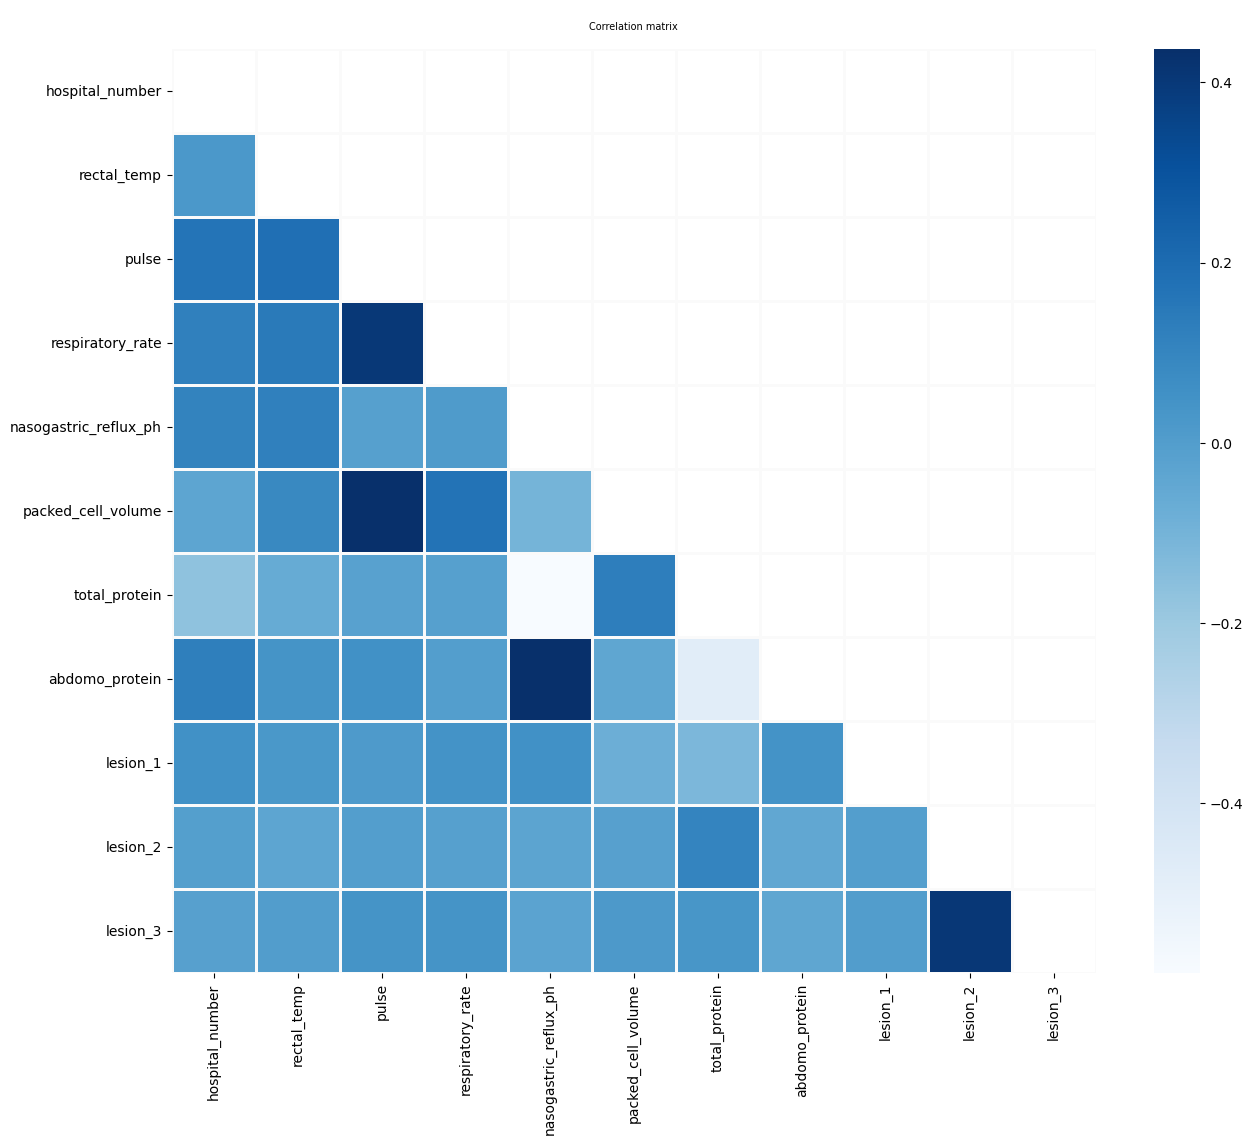

In [65]:
corr_matrix = train.select_dtypes(include=np.number).corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,12))
sns.heatmap(data=corr_matrix, mask=mask, cmap='Blues', linewidths=1, square=True, linecolor='#fafafa')
plt.title('\nCorrelation matrix\n', fontsize=7)
plt.show()

📔 Correlation : is basically a mesure of how two or more variables change together either in the same or the opposite direction. For example the more time you spend studying, the higher your grades tend to be - positive correlation (if one increases then other increases). Or the more fast food you consume, the lower your overall health - negative correlation (one increases when other decreases).

📔 Correlation matrix : dispalys correlation coefficiants between variables. Understanding it can help discover relationships between variables, determine important variables for predictive modeling and uncover underlying patterns in data. Because correlation matrix is symmetrical along its diagonal (A, B are features, corr(A, B) == corr(B, A)) and correlation of a feature with itself is equal to 1 (corr(A, A) == 1) so I plotted it without an upper traingle.

In [66]:
categorical_cols = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane','capillary_refill_time','pain','peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance','lesion_2','surgery', 'age', 'surgical_lesion', 'lesion_3', 'cp_data']
threshold = .05

print(f'{"Column":<25} | Test result')
print('----------------------------------------')

for column in categorical_cols:
    # Create a contingency table
    contingency_table = pd.crosstab(train[column], train['outcome'])
    
    # Perform the Chi-Square test
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    print(f'{column:<25} |   ', '\033[32mPassed' if p < threshold else '\033[31mFailed', '\033[0m')

Column                    | Test result
----------------------------------------
temp_of_extremities       |    Passed 
peripheral_pulse          |    Passed 
mucous_membrane           |    Passed 
capillary_refill_time     |    Passed 
pain                      |    Passed 
peristalsis               |    Passed 
abdominal_distention      |    Passed 
nasogastric_tube          |    Passed 
nasogastric_reflux        |    Passed 
rectal_exam_feces         |    Passed 
abdomen                   |    Passed 
abdomo_appearance         |    Passed 
lesion_2                  |    Passed 
surgery                   |    Passed 
age                       |    Passed 
surgical_lesion           |    Passed 
lesion_3                  |    Failed 
cp_data                   |    Passed 


📔 Chi-square : test of independence of variables is used to assess whether two categorical variables are related to each other. It's often used for feature selection with categorical features in a dataset. We define a threshold against which we will test our feature's p-value and decide whether to drop ones that failed it. In this case setting threshold to 0.05 and dropping lesion_3 column that didn't pass the test slightly improves models performance.

## Feature Engineering

In [67]:
# drop lesion_3
train.drop('lesion_3', axis=1, inplace=True)

#train.drop(columns='lesion_3', inplace=True) does the same thing


## Preprocessing

In [68]:
X_train = train.drop(columns='outcome')
y_train = train[['outcome']]

📔 Target shape : By using dataframe[[cols...]] notation instead of dataframe[col] y_train will be of shape (n_examples, 1) and not a tuple (n_examples, ). Later in this section we will use OrdinalEncoder which needs its input to be of shape (n, 1).
train['outcome'] -> pd.Series
train[['outcome']] -> pd.DataFrame
Pandas DataFrames are of shape (n, cols) and Series are always (n, ) shape which means they don't have columns..

## Pipelines

In [69]:
numerical_pipeline = make_pipeline(
# SimpleImputer(strategy='mean'), #Tree based models like LGBM deal with missing values better than SimpleImputer
QuantileTransformer(output_distribution='normal', random_state=42), StandardScaler())

categorical_pipeline = make_pipeline(
# SimpleImputer(strategy='most_frequent'), 
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)
)

📉 Transformers :
SimpleImputer replaces missing NaN values in every column with either a mean, median or most frequent occurance of that column.
QuantileTransformer tries to change distribution of each feature to match the normal distribution as closely as possible which is prefered by ML models. Not only that but it will help to lessen the impact of outliers on our model.
StandardScaler standardizes features by changing mean of each column to 0, standard deviation to 1.
OrdinalEncoder encodes categorical features as integers. Instead of it you can use OneHotEncoder but in this competition OrdnialEncoder gives a beter score.

📔 Transformer order : It's very important that StandardScaler is used last otherwise QuantileTransformer will negate the effect of it.

## Main transformer

In [70]:
transformer = make_column_transformer(
    (
        numerical_pipeline,
        make_column_selector(dtype_include=np.number) # We want to apply numerical_pipeline only on numerical columns
    ),
    (
        categorical_pipeline,
        make_column_selector(dtype_include=object) # We want to apply categorical_pipeline only on object (string) columns
    ),
    remainder='passthrough', # If any column where missed then don't drop them - we take care of every column so this line is not necessery
    verbose_feature_names_out=False # if False transformer won't add prefixes (name of the transformer that generated specific feature) to column names, column names are shorter that way
)

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('quantiletransformer',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017758C05AB0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=10))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017758C04BE0>)],
                  verbose_feature_names_out=False)

🖊️ Note : I'm using make_pipeline and make_column_transformer because they are simpler to use than a Pipeline and ColumnTransformer. The main difference is that transformer's names are set to their types automatically so you don't have to name each one by hand.

## Target encoder

In [71]:
target_encoder = OrdinalEncoder(categories=[['died', 'euthanized', 'lived']])

📔 OrdinalEncoder vs LabelEncoder : In this case it's better to use OrdnialEncoder because our target classes have hierarchy. In simple terms, if your categorical data has a specific order (like ‘low’, ‘medium’, ‘high’), use OrdnialEncoder. If it doesn’t (like ‘cat’, ‘dog’, ‘whale’), use LabelEncoder

## Transforming 

In [72]:
X_train = transformer.fit_transform(X_train)
y_train = target_encoder.fit_transform(y_train).ravel()

# If we saved y_train as pd.Series, we would have to use this 
#y_train = target_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

#There is even simpler approach without OrdinalEncoder
#y_train = y_train.map({'died':0, 'euthanized':1, 'lived':2})

📉 Target's shape : OrdinalEncoder's inputs must be of shape (n, 1) and if y_train would be a pandas Series with shape (n, ) we'd need to convert it to a numpy array by getting .values and then reshaping it to a desired shape. At the end I'm using ravel() which flattens our (n, 1) numpy array to (n, ) because LGBMClassifier model needs training data to be in a tuple shape.

## Results

In [73]:
X_train = pd.DataFrame(data=X_train, columns=transformer.get_feature_names_out(), index=train.index)
X_train.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,...,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
0,0.057095,-0.105176,1.697071,-0.179003,0.592625,0.611696,0.500502,0.136370,0.216763,-0.099009,...,2.0,1.0,4.0,3.0,1.0,2.0,2.0,3.0,1.0,0.0
1,0.458369,-0.954654,0.391484,-1.397126,-0.657591,-1.485044,0.916959,-0.736104,0.086126,-0.099009,...,4.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0
2,-0.011091,0.246450,1.297950,0.035993,-0.204320,-0.977396,-0.925561,0.136370,0.765270,-0.099009,...,3.0,4.0,1.0,3.0,3.0,0.0,1.0,3.0,1.0,0.0
3,1.305770,-1.557301,-0.024405,0.172761,-0.657591,0.349631,-0.381942,0.469022,0.086126,-0.099009,...,4.0,4.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0
4,2.402205,-0.324284,-0.707712,1.065178,0.925073,-0.124186,-0.164811,-0.204551,-2.711674,-0.099009,...,1.0,4.0,2.0,3.0,1.0,4.0,4.0,2.0,0.0,1.0


In [74]:
X_train.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,...,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
count,1.534000e+03,1.474000e+03,1.510000e+03,1.476000e+03,1.288000e+03,1.505000e+03,1.501000e+03,1.336000e+03,1.534000e+03,1.534000e+03,...,1479.000000,1490.000000,1478.000000,1430.000000,1428.000000,1432.000000,1416.000000,1369.000000,1534.000000,1534.000000
mean,9.263921e-18,1.205127e-18,3.293907e-17,-2.406988e-17,-1.517075e-17,4.721214e-18,-3.550347e-18,-6.648042e-18,-4.631960e-17,-1.510019e-15,...,2.983773,2.888591,2.214479,2.246853,2.067927,1.785615,1.707627,2.161432,0.729465,0.500000
std,1.000326e+00,1.000339e+00,1.000331e+00,1.000339e+00,1.000388e+00,1.000332e+00,1.000333e+00,1.000374e+00,1.000326e+00,1.000326e+00,...,1.327244,1.488146,1.281346,1.003096,0.769246,1.321008,1.228909,0.884947,0.444381,0.500163
min,-5.135410e+00,-5.016969e+00,-4.968210e+00,-4.815955e+00,-3.576589e+00,-4.239160e+00,-5.059221e+00,-5.034649e+00,-2.711674e+00,-9.900892e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.677049e-01,-5.997442e-01,-7.077123e-01,-6.357315e-01,-6.575915e-01,-5.738491e-01,-6.319989e-01,-7.361039e-01,-2.229343e-01,-9.900892e-02,...,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,2.540240e-03,6.830837e-02,-2.440453e-02,3.599269e-02,2.019884e-02,-1.190616e-02,1.033596e-02,-1.079421e-02,2.167628e-01,-9.900892e-02,...,3.000000,4.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.500000
75%,6.666595e-01,7.202357e-01,5.946787e-01,4.927368e-01,5.193900e-01,4.774381e-01,6.660752e-01,6.515126e-01,5.152658e-01,-9.900892e-02,...,4.000000,4.000000,4.000000,3.000000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000
max,5.135534e+00,5.022670e+00,4.962537e+00,4.779062e+00,3.665929e+00,4.136497e+00,5.050619e+00,5.003372e+00,3.085026e+00,1.303069e+01,...,6.000000,5.000000,4.000000,3.000000,4.000000,5.000000,5.000000,3.000000,1.000000,1.000000


✅ Great : Now columns have zero mean, std equal to one and distribution closer to normal so the model will learn faster and more efficient.

## Modeling

In [75]:
## Splitting training data

X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(X_train, y_train, train_size=0.9)


📔 Splitting proportions : Most popular ratio I use in playground is propably 80/20 and 90/10 where 80%/90% goes for training and rest is used in validation/cross-validation. But it's by no means set in stone and will differ a lot when for example you have a very large dataset with over 100k examples. Then you can split the data in 99/1 proportions beacuse then you will still have over a thousand examples to validate your model on which is enough. One other exception is dealing with time series data if you have sales records from a few years and your model will be used for predicting whole next year sales for each month. Then it would be reasonable to assign 1 year of data for validation beacuse you want to validate your model on data similar to the one that it will be used in real world. So remember to always pay attention how to split your dataset.

## Hyperparameter Optimization

In [76]:
def objective(trial): 
    
#     model = LGBMClassifier(
#         n_estimators = trial.suggest_int('n_estimators', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5),
#         max_depth = trial.suggest_int('max_depth', 1, 10),
#         num_leaves = trial.suggest_int('num_leaves', 2, 1024),
#         reg_lambda  = trial.suggest_float('reg_lambda', 0.001, 10),
#         reg_alpha = trial.suggest_float('reg_alpha', 0, 10),
#         subsample = trial.suggest_float('subsample', 0.001, 1),
#         colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1),
#         min_child_samples = trial.suggest_int('min_child_samples', 2, 1024),
#         min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
#         objective = trial.suggest_categorical('objective', ['multiclass']),
#         metric = trial.suggest_categorical('metric', ['multi_logloss']),
#         boosting_type = trial.suggest_categorical('boosting_type', ['gbdt']),
#     )
    
#     model = CatBoostClassifier(
#         iterations = trial.suggest_int('iterations', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         depth = trial.suggest_int('depth', 1, 10),
#         l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 10),
#         grow_policy = trial.suggest_categorical('grow_policy', ['Depthwise']),
#         bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian']),
#         od_type = trial.suggest_categorical('od_type', ['Iter']),
#         eval_metric = trial.suggest_categorical('eval_metric', ['TotalF1']),
#         loss_function = trial.suggest_categorical('loss_function', ['MultiClass']),
#         random_state = trial.suggest_categorical('random_state', [42]),
#         verbose = trial.suggest_categorical('verbose', [0])
#     )

    model = XGBClassifier(
        eta = trial.suggest_float('eta', 0.001, 0.3),
        n_estimators = trial.suggest_int('n_estimators', 32, 1024),
        max_depth = trial.suggest_int('max_depth', 1, 10),
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10),
        subsample = trial.suggest_float('subsample', 0.01, 1),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1),
        objective = trial.suggest_categorical('objective', ['multi:softmax'])
    )
    
    model.fit(
        X_train_optuna, y_train_optuna,
        eval_set=[(X_train_optuna, y_train_optuna), (X_val_optuna, y_val_optuna)],
        verbose=False
    )
    
    return f1_score(y_val_optuna, model.predict(X_val_optuna), average='micro') # micro F1 is used in this competitons for evaluation so we will use it for hyperparameter optimization

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_hyperparams = study.best_params 

📔 Hyperparameter ranges : Machine learning models oftentimes prefer powers of 2 so it's a good practice to set hyperparameter ranges to them but it's by no means necessary and most of the times will not have any impact on models performance.

In [77]:
best_hyperparams_xgb = {'eta': 0.2734096744203229, 'n_estimators': 251, 'max_depth': 1, 'reg_lambda': 1.3536521735953297, 'subsample': 0.9372043032806799, 'min_child_weight': 5, 'colsample_bytree': 0.32973413695986586, 'objective': 'multi:softmax'}
best_hyperparams_lgbm = {'n_estimators': 146, 'learning_rate': 0.09732455260435911, 'max_depth': 8, 'num_leaves': 973, 'reg_lambda': 5.558974411222393, 'reg_alpha': 5.94913795893992, 'subsample': 0.057493821911338956, 'colsample_bytree': 0.7716515051686431, 'min_child_samples': 46, 'min_child_weight': 7, 'objective': 'multiclass', 'metric': 'multi_logloss', 'boosting_type': 'gbdt'}
best_hyperparams_cb = {'iterations': 210, 'learning_rate': 0.21569043805753133, 'depth': 3, 'l2_leaf_reg': 6.171143053175511, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'od_type': 'Iter', 'eval_metric': 'TotalF1', 'loss_function': 'MultiClass', 'random_state': 42, 'verbose': 0}

## Models

In [78]:
models = [
    XGBClassifier(**best_hyperparams_xgb),
    LGBMClassifier(**best_hyperparams_lgbm),
    CatBoostClassifier(**best_hyperparams_cb)
]

## Model evaluation

In [85]:
for model in models:
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_micro').sum() / 5

    print(f'{model.__class__.__name__} micro F1 cross-validation score: {cv_score:.3f}')

XGBClassifier micro F1 cross-validation score: 0.714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1227, number of used features: 25
[LightGBM] [Info] Start training from score -1.148748
[LightGBM] [Info] Start training from score -1.648496
[LightGBM] [Info] Start training from score -0.712070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1227, number of used features: 25
[LightGBM] [Info] Start training from score -1.146181
[LightGBM] [Info] Start training from score -1.648496
[LightGBM] [Info] Start training from score -0.713733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

CatBoostClassifier micro F1 cross-validation score: 0.728


📔 Cross-validation : is a method giving more accurate performance evaluation of a model compared to normal validation. It involves dividing the original data into several subsets - 5 in this case. Then model is trained on 4 of those and is scored on the remaining one. It's repeated 5 times, each time last fold is different and model is trained on the rest. I haven't used cross-validation in optuna because this method is computationaly expensive. Basically number next to cv attribute is an amount of times our model will be trained. So if optuna runs for 50 iterations it would train our model 250 times witch cross-validation instead of 50.

## Model training

In [86]:
for model in models:
    model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 25
[LightGBM] [Info] Start training from score -1.147370
[LightGBM] [Info] Start training from score -1.648659
[LightGBM] [Info] Start training from score -0.712898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [88]:
for model in models:
    train_score = f1_score(y_train, model.predict(X_train), average='micro')

    print(f'{model.__class__.__name__} micro F1 training score: {train_score:.3f}')

XGBClassifier micro F1 training score: 0.788
LGBMClassifier micro F1 training score: 0.857
CatBoostClassifier micro F1 training score: 0.866


⚠️ Overfitting: F1 score ranges from [0, 1] so 0.06 to 0.15 difference in cross-validation score to training score is a sign of overfitting to the training set also known as a high variance problem. It means that our model predicts data that it has seen very well but has a trouble generalizing to unseen data. To fix that we will ensamble our models into one.

## Feature importance

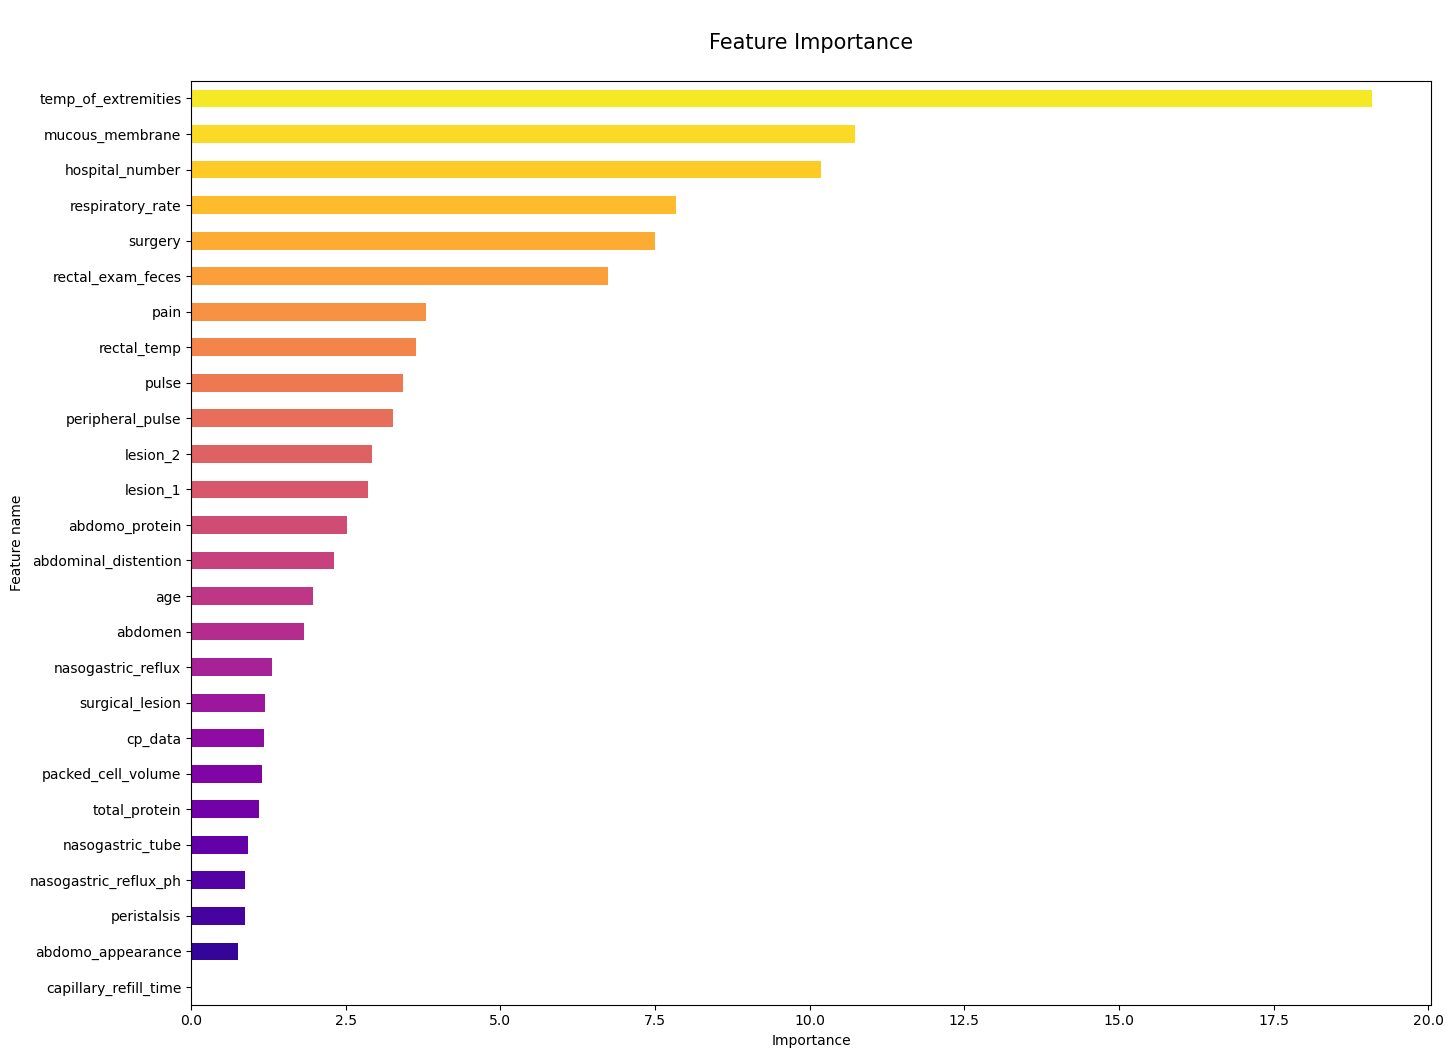

In [91]:
feature_importance = pd.DataFrame(data = {'feature': train.columns[:-1], 'importance': model.feature_importances_})

feature_importance = feature_importance.sort_values('importance', ascending=True)

feature_importance.plot(kind='barh', x='feature', y='importance', legend=False, color=sns.color_palette('plasma', n_colors=len(feature_importance)), figsize=(16,12))

plt.xlabel('Importance')
plt.ylabel('Feature name')
plt.title('\nFeature Importance\n', fontsize=15)
plt.show()

📔 Feature importance : assigns a score to input features based on how useful they are at predicting a target variable. It provides an understanding of which features have the most impact on a model’s predictions. This can be particularly useful in feature selection, improving model interpretability, and understanding the data.

## Submission

In [92]:
test.drop('lesion_3', axis=1, inplace=True)

X_test = pd.DataFrame(data=transformer.transform(test), columns=transformer.get_feature_names_out(), index=test.index)


In [94]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test).ravel()) # CatBoostClassifier's predictions are of shape (n ,1) and not (n, ) like other models so we have to use .ravel()

# Mode doesn't work on python lists only on ndarray (numpy arrays)
predictions = np.array(predictions)

# Take the most frequent prediction out of 3 models
final_predictions, _ = stats.mode(predictions, axis=0, keepdims=False)

final_predictions.shape

(824,)

In [96]:
submission = pd.read_csv('sample_submission.csv', index_col='id')

submission['outcome'] = target_encoder.inverse_transform(final_predictions.reshape(-1, 1)).ravel()
submission.to_csv('submission.csv')

